In [1]:
import principal_portfolios as pp
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from functools import reduce

### Reading MS data

In [2]:
data_to_read_address = "data/MSFX.xlsx"
fx_ms_df = pd.read_excel(data_to_read_address)

dfs = []

# Loop through the dataframe, two columns at a time (one for date, one for value)
for i in range(0, len(fx_ms_df.columns), 2):
    date_col = fx_ms_df.columns[i]
    value_col = fx_ms_df.columns[i + 1]
    
    # Rename the columns for clarity
    instrument_name = date_col.replace(' Index', '')
    
    # Create a new dataframe for the current instrument
    temp_df = fx_ms_df[[date_col, value_col]].copy()
    temp_df.columns = ['date', instrument_name]
    
    # Remove rows where the date is NaT or NaN in both columns
    temp_df = temp_df.dropna(subset=['date', instrument_name])
    
    # Append the dataframe to the list
    dfs.append(temp_df)

# Perform an inner join on the 'date' column for all dataframes
merged_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)

# Remove any remaining rows with NaT or NaN after merging
merged_df.dropna(inplace=True)
merged_df

,date,MSCEAUDL,MSCEAUDS,MSCEGBPL,MSCEGBPS,MSCECADL,MSCECADS,MSCEEURL,MSCEEURS,MSCEJPYL,...,MSCEERSE,MSCEGBLG,MSCEGBSG,MSCECOLU,MSCECOSU,MSCEEFXU,MSCECARU,MSCEQSIU,MSCERERU,MSCEPOSU
0,2002-01-15,99.476,100.609,99.676,100.414,100.501,99.600,98.803,101.302,99.935,...,100.409,83.273,72.772,40.589,197.651,15.891,28.517,32.282,38.644,34.372
1,2002-01-16,99.084,101.012,99.436,100.661,99.865,100.244,98.792,101.322,99.216,...,100.996,83.320,72.744,40.454,198.327,15.834,28.423,32.074,38.667,34.485
2,2002-01-17,98.903,101.204,99.336,100.771,99.046,101.064,98.599,101.529,98.864,...,101.196,83.433,72.661,40.358,198.815,15.899,28.456,32.176,38.667,34.720
3,2002-01-22,99.958,100.172,98.905,101.252,99.302,100.846,99.278,100.875,97.894,...,100.719,82.924,73.180,40.642,197.507,16.271,28.889,32.675,39.512,35.189
4,2002-01-23,99.720,100.422,98.667,101.503,99.741,100.406,98.313,101.873,97.384,...,100.472,82.704,73.387,40.571,197.868,16.242,28.650,32.832,39.693,35.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4677,2021-12-09,258.960,44.858,124.514,105.255,164.292,81.237,143.144,93.359,108.132,...,109.709,84.052,110.880,82.135,127.976,109.479,85.285,117.357,96.297,121.420
4678,2021-12-10,259.921,44.693,124.716,105.084,164.268,81.249,143.383,93.205,108.151,...,109.683,84.079,110.842,82.447,127.501,109.066,84.651,117.082,96.446,120.765
4679,2021-12-13,257.928,45.038,124.721,105.080,163.019,81.867,143.013,93.446,108.008,...,109.846,84.276,110.574,81.692,128.681,109.109,85.655,117.500,95.751,120.946
4680,2021-12-14,258.037,45.019,124.773,105.037,162.569,82.089,142.985,93.464,107.874,...,109.840,84.345,110.480,81.561,128.882,108.803,85.939,117.494,95.360,120.712


In [3]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Step 2: Set 'Date' as the index to enable resampling
merged_df.set_index('date', inplace=True)

# Step 3: Resample to get the last price of each month (monthly frequency 'M')
monthly_prices = merged_df.resample('M').last()

# Step 4: Calculate the monthly returns for each column (except 'Date')
monthly_returns = monthly_prices.pct_change() * 100

# Step 5: Reset the index to have 'Date' as a column again
monthly_returns.reset_index(inplace=True)
monthly_returns.dropna(inplace=True)

In [4]:
corr_matrix = monthly_returns.iloc[:,1:].corr()
to_drop = []

# Iterate over the columns of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.98 or corr_matrix.iloc[i, j] < -0.98:
            colname = corr_matrix.columns[j]
            if colname not in to_drop:
                to_drop.append(colname)

# Now drop the identified columns from the dataframe, keeping only the first
filtered_corr_matrix = corr_matrix.drop(columns=to_drop, index=to_drop)
columns_to_keep = filtered_corr_matrix.columns.to_list()

In [5]:
print(len(columns_to_keep))
columns_to_keep

33


['MSCEAUDL ',
 'MSCEGBPL ',
 'MSCECADL ',
 'MSCEEURL ',
 'MSCEJPYL ',
 'MSCENZDL ',
 'MSCENOKL ',
 'MSCESEKL ',
 'MSCECHFL ',
 'MSCEEAL ',
 'MSCEEGL ',
 'MSCEECL ',
 'MSCEEJL ',
 'MSCEEZL ',
 'MSCEENL ',
 'MSCEESL ',
 'MSCEEHL ',
 'MSCEGAL ',
 'MSCEGCL ',
 'MSCEGJL ',
 'MSCEGZL ',
 'MSCEGNL ',
 'MSCEGSL ',
 'MSCEGHL ',
 'MSCEUSLU ',
 'MSCEERLE ',
 'MSCEGBLG ',
 'MSCECOLU ',
 'MSCEEFXU ',
 'MSCECARU ',
 'MSCEQSIU ',
 'MSCERERU ',
 'MSCEPOSU ']

In [6]:
processed_df = monthly_returns[['date']+columns_to_keep]
basket_portfolios = processed_df.iloc[:,-5:]
basket_portfolios.insert(0, 'date', processed_df['date'])

### Reading DB data

In [7]:
data_to_read_address = "data/DB_FX_portfolio.xlsx"
db_data_df = pd.read_excel(data_to_read_address)
db_data_df.dropna(inplace=True)

In [8]:
db_data_df['date'] = pd.to_datetime(db_data_df['date'])

# Step 2: Set 'Date' as the index to enable resampling
db_data_df.set_index('date', inplace=True)

# Step 3: Resample to get the last price of each month (monthly frequency 'M')
monthly_db_prices = db_data_df.resample('M').last()

# Step 4: Calculate the monthly returns for each column (except 'Date')
monthly_db_returns = monthly_db_prices.pct_change() * 100

# Step 5: Reset the index to have 'Date' as a column again
monthly_db_returns.reset_index(inplace=True)
monthly_db_returns.dropna(inplace=True)

In [9]:
monthly_db_returns

,date,Deutsche Bank FX Valuation USD Index,Deutsche Bank CoreSeries FX Carry Balanced USD Index,Deutsche Bank CoreSeries FX Carry Global USD Index,Deutsche Bank FX Momentum USD Index
1,2002-04-30,-2.856305,2.138505,1.198208,-0.105282
2,2002-05-31,1.248650,1.827165,-0.264381,3.373320
3,2002-06-30,-4.763009,-1.972973,-4.104920,3.342460
4,2002-07-31,-3.199150,-0.828584,0.047092,0.057761
5,2002-08-31,0.680392,2.055886,1.982307,-1.222818
...,...,...,...,...,...
267,2024-06-30,-2.023115,-0.330827,-1.214382,-0.156000
268,2024-07-31,1.665012,-2.572832,-2.002088,-2.522742
269,2024-08-31,0.308823,-3.449892,-3.942724,1.002477
270,2024-09-30,0.088742,-0.025163,0.345458,-0.617035


## Meging the two files

In [13]:
basket_portfolios = basket_portfolios.merge(monthly_db_returns,how='inner', on='date')

## PP 

dict_keys(['fx_ms_portfolio_momentum_monthly'])
dict_keys(['realized_returns_df', 'sharpe_df', 'pp_realized_mean_df', 'pp_expected_mean_df', 'pep_realized_mean_df', 'pep_expected_mean_df', 'pap_realized_mean_df', 'pap_expected_mean_df'])
return_of_simple_factor           0.252114
realized_return_of_first_n_PP     0.187029
realized_return_of_first_n_PEP    0.233089
realized_return_of_first_n_PAP   -0.030921
realized_return_of_1_PP          -0.151500
realized_return_of_1_PEP          0.013971
realized_return_of_2_PP           0.327278
realized_return_of_2_PEP          0.079383
realized_return_of_3_PP           0.085857
realized_return_of_3_PEP          0.519738
realized_return_of_4_PP           0.226424
realized_return_of_4_PEP         -0.038610
realized_return_of_5_PP          -0.131409
realized_return_of_5_PEP          0.305069
realized_return_of_6_PP           0.083157
realized_return_of_6_PEP          0.137641
realized_return_of_7_PP          -0.198954
realized_return_of_7_PEP       

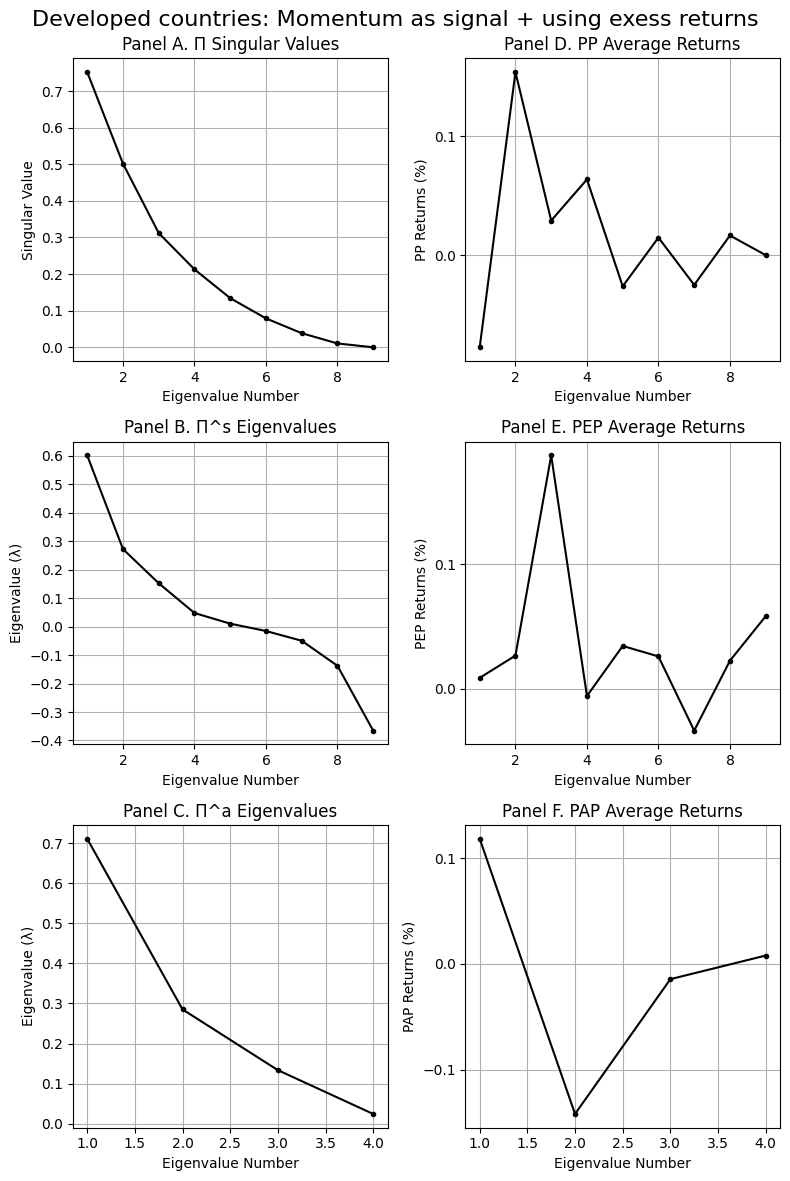

In [33]:
starting_year_to_filter = 1996
end_year_to_filter = 2024
number_of_lookback_periods = 60
number_of_PPs_to_consider = 4
number_of_PEPs_to_consider = 4
number_of_PAPs_to_consider = 2
output_dict_momentum = {}


basket_portfolios['date'] = pp.convert_date_column_for_monthly_data(basket_portfolios)
signal_df = pp.build_signal_df_for_1month_momentum(basket_portfolios)



portfolios_key = "fx_ms_portfolio_momentum_monthly"
output_dict_momentum[portfolios_key] = pp.build_PP(basket_portfolios,signal_df,
                                                                   number_of_lookback_periods,starting_year_to_filter,end_year_to_filter,
                                                                   factor_data_monthly=None, number_of_PPs_to_consider=number_of_PPs_to_consider,
                                                                   number_of_PEPs_to_consider=number_of_PEPs_to_consider, 
                                                                   number_of_PAPs_to_consider= number_of_PAPs_to_consider)

# I calculate the results for all datasets. the results are stored in this dictionay.
print(output_dict_momentum.keys())
'''
Every value of this dictionary is itself another dictionary.
For instance the key 'sharpe_df' can be used to access the sharp values of this set of results.
'''
print(output_dict_momentum[portfolios_key].keys())
print(output_dict_momentum[portfolios_key]["sharpe_df"])

number_of_portfolios = basket_portfolios.shape[1]
title = 'Developed countries: Momentum as signal + using exess returns'

pp.singular_values_vs_realized_returns_graph(output_dict_momentum, portfolios_key, number_of_portfolios, title)

In [29]:
pp.calculate_sharpe_ratio(basket_portfolios.iloc[number_of_lookback_periods:,1:].mean(axis=1)) * math.sqrt(12)

0.7588137882857049

In [30]:
basket_portfolios.iloc[number_of_lookback_periods:,1:].apply(lambda col: pp.calculate_sharpe_ratio(col)) * math.sqrt(12)

MSCEEFXU                                                0.733723
MSCECARU                                                0.090771
MSCEQSIU                                                0.633065
MSCERERU                                                0.516513
MSCEPOSU                                                0.406829
Deutsche Bank FX Valuation USD Index                    0.330350
Deutsche Bank CoreSeries FX Carry Balanced USD Index    0.276092
Deutsche Bank CoreSeries FX Carry Global USD Index      0.218250
Deutsche Bank FX Momentum USD Index                    -0.042340
dtype: float64

In [32]:
basket_portfolios.iloc[:,1:].corr()

,MSCEEFXU,MSCECARU,MSCEQSIU,MSCERERU,MSCEPOSU,Deutsche Bank FX Valuation USD Index,Deutsche Bank CoreSeries FX Carry Balanced USD Index,Deutsche Bank CoreSeries FX Carry Global USD Index,Deutsche Bank FX Momentum USD Index
MSCEEFXU,1.000000,0.508135,0.352735,0.463409,0.525593,0.091769,0.155455,0.098727,0.308874
MSCECARU,0.508135,1.000000,-0.077066,-0.090139,0.378489,-0.125622,0.447381,0.345035,0.087748
MSCEQSIU,0.352735,-0.077066,1.000000,0.008589,-0.020893,-0.006686,-0.066131,-0.033056,-0.031610
MSCERERU,0.463409,-0.090139,0.008589,1.000000,0.005042,0.401387,-0.151903,-0.133223,-0.041743
MSCEPOSU,0.525593,0.378489,-0.020893,0.005042,1.000000,-0.140767,0.075683,0.062087,0.479439
Deutsche Bank FX Valuation USD Index,0.091769,-0.125622,-0.006686,0.401387,-0.140767,1.000000,-0.127847,-0.148851,-0.070717
Deutsche Bank CoreSeries FX Carry Balanced USD Index,0.155455,0.447381,-0.066131,-0.151903,0.075683,-0.127847,1.000000,0.947589,-0.095005
Deutsche Bank CoreSeries FX Carry Global USD Index,0.098727,0.345035,-0.033056,-0.133223,0.062087,-0.148851,0.947589,1.000000,-0.138825
Deutsche Bank FX Momentum USD Index,0.308874,0.087748,-0.031610,-0.041743,0.479439,-0.070717,-0.095005,-0.138825,1.000000
